In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn.naive_bayes
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV


# San-Francisco 

In [21]:
sf_data = pd.read_csv("../data/cleaned_data/SanFrancisco.csv")
sf_data.columns

Index(['Unnamed: 0', 'Dates', 'Category', 'DayOfWeek', 'PdDistrict', 'Address',
       'X', 'Y', 'year', 'month', 'day', 'hour', 'violent', 'street1',
       'street2', 'str1', 'str2'],
      dtype='object')

In [22]:
sf_data["street2"].drop_duplicates().shape[0]

1691

In [23]:
def all_metrics(y_true, y_pred):
    print("accuracy:\t{:.3f}".format(metrics.accuracy_score(y_true, y_pred)))
    print("sensitivity: \t{:.3f}".format(metrics.recall_score(y_true, y_pred)))
    print("specificity: \t{:.3f}".format(metrics.recall_score(y_true, y_pred, pos_label=0)))
    print("kappa:    \t{:.3f}".format(metrics.cohen_kappa_score(y_true, y_pred)))

In [24]:
def all_metrics_tex(y_true, y_pred):
    def format_print(name, function, quad = True):
            print(r"\mathrm{",name,"}:"," {:.3f}".format(function(y_true, y_pred)),",\\quad" if quad else "", sep='')

    print(r"\begin{align*}")
    format_print("accuracy", metrics.accuracy_score)
    format_print("sensitivity", metrics.recall_score)
    format_print("specificity", lambda y1, y2: metrics.recall_score(y1, y2, pos_label=0))
    format_print("kappa", metrics.cohen_kappa_score, quad=False)
    print(r"\end{align*}")


In [25]:
def prepare_data_(random = 0, test_size =0.3, strs = False, catPdDistrict = False):
    data = sf_data.drop(columns=["Unnamed: 0", "Dates", "Category", "street1", "street2", "Address"])
    if(not strs):
        data = data.drop(columns=["str1", "str2"])
    if(not catPdDistrict):
        data["PdDistrict"] = data["PdDistrict"].map({d:i for i, d in enumerate(sf_data["PdDistrict"].drop_duplicates())})
    X_train, X_test, y_train, y_test = train_test_split(
            pd.get_dummies(data.drop(columns=["violent"])),
            data["violent"], 
            test_size=test_size, random_state=random)
    return X_train, X_test, y_train, y_test
#
def prepare_data(data_name, random = 0, test_size = 0.3):
    if data_name == "paper":
        return prepare_data_(random=random, test_size=test_size, strs=False, catPdDistrict=False)
    elif data_name == "catPdDistrict":
        return prepare_data_(random=random, test_size=test_size, strs=False, catPdDistrict=True)
    elif data_name == "catPdDistrict_strs":
        return prepare_data_(random=random, test_size=test_size, strs=True, catPdDistrict=True)
    else:
        print("Unknown data_name=", data_name)

    

In [31]:
def save_figure(file_name, save = True):
    if save:
        print("Saving figure to file ./cs5630_final_TeX/figures/"+file_name+".pdf")
        plt.savefig("../cs5630_final_TeX/figures/"+file_name+".pdf")

In [5]:
param_grid = {'max_depth': [3, 5, 10], 'min_samples_split': [2, 5, 10]}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

## Paper dataset

In [28]:
# Split dataset into 70% training set and 30% test set
X_train, X_test, y_train, y_test = prepare_data("paper")

In [7]:
rf_regressor = RandomForestClassifier(verbose=1)
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0, verbose = 1)

In [ ]:
grid_result = grid_search.fit(X_train, y_train)
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [24]:
grid_result.best_params_

{'max_depth': 10, 'min_samples_split': 5}

In [8]:
rf_classifier = RandomForestClassifier(max_depth=10, min_samples_split=5)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=5)

accuracy:	0.597
sensitivity: 	0.652
specificity: 	0.541
kappa:    	0.194


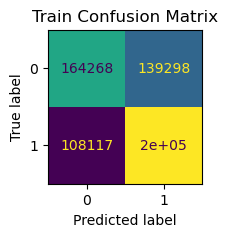

In [27]:
y_train_pred = rf_classifier.predict(X_train)
cm_train = confusion_matrix(y_train, y_train_pred)

disp = ConfusionMatrixDisplay(cm_train)
fig, ax = plt.subplots(figsize=(2, 2))
disp.plot(ax=ax, colorbar = None)
plt.title("Train Confusion Matrix")

all_metrics(y_train, y_train_pred)

accuracy:	0.587
sensitivity: 	0.641
specificity: 	0.531
kappa:    	0.173


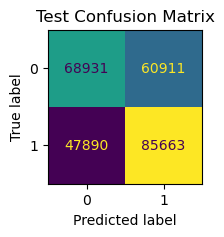

In [31]:
y_test_pred = rf_classifier.predict(X_test)
cm_test = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(cm_test)
fig, ax = plt.subplots(figsize=(2, 2))
disp.plot(ax=ax, colorbar = None)
plt.title("Test Confusion Matrix")

all_metrics(y_test, y_test_pred)

### max_d = 100, min_d = 5

In [15]:
rf_classifier = RandomForestClassifier(max_depth=100, min_samples_split=5)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=100, min_samples_split=5)

In [16]:
estimator = rf_classifier.estimators_[1]

In [17]:
from sklearn.tree import export_graphviz
export_graphviz(estimator, 
                out_file='tree.dot',
                feature_names=X_train.columns,
                rounded=True, proportion=False, precision=2, filled=True)

In [18]:
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.000971032 to fit


0

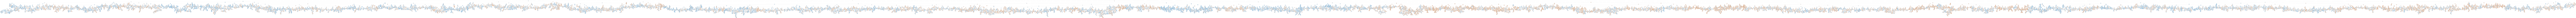

In [14]:
from IPython.display import Image
Image(filename = 'tree.png')

accuracy:	0.924
sensitivity: 	0.927
specificity: 	0.920
kappa:    	0.847


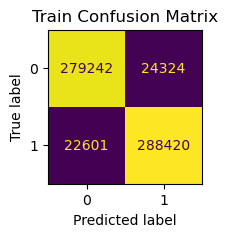

In [44]:
y_train_pred = rf_classifier.predict(X_train)
cm_train = confusion_matrix(y_train, y_train_pred)

disp = ConfusionMatrixDisplay(cm_train)
fig, ax = plt.subplots(figsize=(2, 2))
disp.plot(ax=ax, colorbar = None)
plt.title("Train Confusion Matrix")

all_metrics(y_train, y_train_pred)

accuracy:	0.605
sensitivity: 	0.637
specificity: 	0.572
kappa:    	0.209


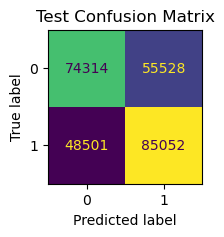

In [45]:
y_test_pred = rf_classifier.predict(X_test)
cm_test = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(cm_test)
fig, ax = plt.subplots(figsize=(2, 2))
disp.plot(ax=ax, colorbar = None)
plt.title("Test Confusion Matrix")

all_metrics(y_test, y_test_pred)

### max_d = 100, min_d = 20

In [46]:
rf_classifier = RandomForestClassifier(max_depth=100, min_samples_split=20)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=100, min_samples_split=20)

accuracy:	0.801
sensitivity: 	0.831
specificity: 	0.771
kappa:    	0.602


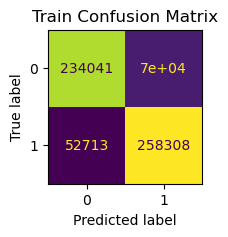

In [47]:
y_train_pred = rf_classifier.predict(X_train)
cm_train = confusion_matrix(y_train, y_train_pred)

disp = ConfusionMatrixDisplay(cm_train)
fig, ax = plt.subplots(figsize=(2, 2))
disp.plot(ax=ax, colorbar = None)
plt.title("Train Confusion Matrix")

all_metrics(y_train, y_train_pred)

accuracy:	0.614
sensitivity: 	0.664
specificity: 	0.563
kappa:    	0.227


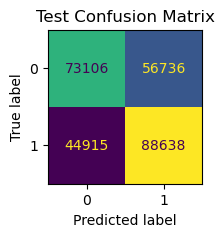

In [48]:
y_test_pred = rf_classifier.predict(X_test)
cm_test = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(cm_test)
fig, ax = plt.subplots(figsize=(2, 2))
disp.plot(ax=ax, colorbar = None)
plt.title("Test Confusion Matrix")

all_metrics(y_test, y_test_pred)

### max_d = 70, min_d = 30

In [49]:
rf_classifier = RandomForestClassifier(max_depth=70, min_samples_split=30)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=70, min_samples_split=30)

accuracy:	0.753
sensitivity: 	0.795
specificity: 	0.710
kappa:    	0.506


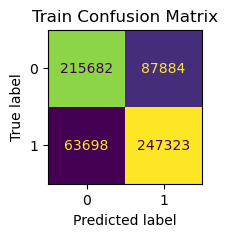

In [50]:
y_train_pred = rf_classifier.predict(X_train)
cm_train = confusion_matrix(y_train, y_train_pred)

disp = ConfusionMatrixDisplay(cm_train)
fig, ax = plt.subplots(figsize=(2, 2))
disp.plot(ax=ax, colorbar = None)
plt.title("Train Confusion Matrix")

all_metrics(y_train, y_train_pred)

accuracy:	0.615
sensitivity: 	0.669
specificity: 	0.560
kappa:    	0.229


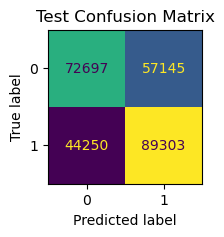

In [51]:
y_test_pred = rf_classifier.predict(X_test)
cm_test = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(cm_test)
fig, ax = plt.subplots(figsize=(2, 2))
disp.plot(ax=ax, colorbar = None)
plt.title("Test Confusion Matrix")

all_metrics(y_test, y_test_pred)

### max_d = 100, min_d = 50

In [29]:
rf_classifier = RandomForestClassifier(max_depth=100, min_samples_split=50)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=100, min_samples_split=50)

Saving figure to file ./cs5630_final_TeX/figures/RF_paper_train.pdf
accuracy:	0.746
sensitivity: 	0.779
specificity: 	0.712
kappa:    	0.491


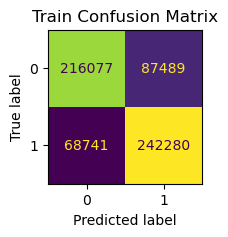

In [32]:
y_train_pred = rf_classifier.predict(X_train)
cm_train = confusion_matrix(y_train, y_train_pred)

disp = ConfusionMatrixDisplay(cm_train)
fig, ax = plt.subplots(figsize=(2, 2))
disp.plot(ax=ax, colorbar = None)
plt.title("Train Confusion Matrix")
save_figure("RF_paper_train")

all_metrics(y_train, y_train_pred)

In [34]:
all_metrics_tex(y_train, y_train_pred)

\begin{align*}
\mathrm{accuracy}: 0.746,\quad
\mathrm{sensitivity}: 0.779,\quad
\mathrm{specificity}: 0.712,\quad
\mathrm{kappa}: 0.491
\end{align*}


Saving figure to file ./cs5630_final_TeX/figures/RF_paper_test.pdf
accuracy:	0.603
sensitivity: 	0.643
specificity: 	0.562
kappa:    	0.205


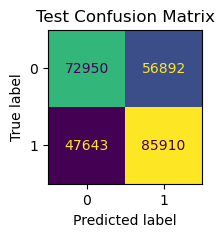

In [35]:
y_test_pred = rf_classifier.predict(X_test)
cm_test = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(cm_test)
fig, ax = plt.subplots(figsize=(2, 2))
disp.plot(ax=ax, colorbar = None)
plt.title("Test Confusion Matrix")
save_figure("RF_paper_test")

all_metrics(y_test, y_test_pred)

In [36]:
all_metrics_tex(y_test, y_test_pred)

\begin{align*}
\mathrm{accuracy}: 0.603,\quad
\mathrm{sensitivity}: 0.643,\quad
\mathrm{specificity}: 0.562,\quad
\mathrm{kappa}: 0.205
\end{align*}


## catPdDistrict

In [37]:
# Split dataset into 70% training set and 30% test set
X_train, X_test, y_train, y_test = prepare_data("catPdDistrict")

### max_d = 10, min_d = 5

In [56]:
rf_classifier = RandomForestClassifier(max_depth=10, min_samples_split=5)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=5)

accuracy:	0.596
sensitivity: 	0.631
specificity: 	0.560
kappa:    	0.192


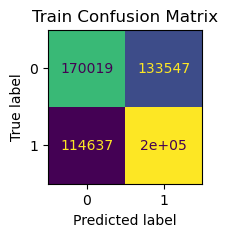

In [57]:
y_train_pred = rf_classifier.predict(X_train)
cm_train = confusion_matrix(y_train, y_train_pred)

disp = ConfusionMatrixDisplay(cm_train)
fig, ax = plt.subplots(figsize=(2, 2))
disp.plot(ax=ax, colorbar = None)
plt.title("Train Confusion Matrix")

all_metrics(y_train, y_train_pred)

accuracy:	0.587
sensitivity: 	0.623
specificity: 	0.551
kappa:    	0.173


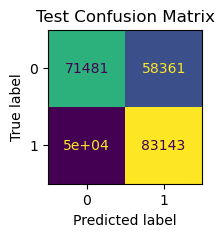

In [58]:
y_test_pred = rf_classifier.predict(X_test)
cm_test = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(cm_test)
fig, ax = plt.subplots(figsize=(2, 2))
disp.plot(ax=ax, colorbar = None)
plt.title("Test Confusion Matrix")

all_metrics(y_test, y_test_pred)

### max_d = 100, min_d = 50

In [38]:
rf_classifier = RandomForestClassifier(max_depth=100, min_samples_split=50)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=100, min_samples_split=50)

Saving figure to file ./cs5630_final_TeX/figures/RF_catPd_train.pdf
accuracy:	0.741
sensitivity: 	0.774
specificity: 	0.707
kappa:    	0.481


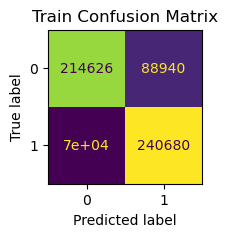

In [39]:
y_train_pred = rf_classifier.predict(X_train)
cm_train = confusion_matrix(y_train, y_train_pred)

disp = ConfusionMatrixDisplay(cm_train)
fig, ax = plt.subplots(figsize=(2, 2))
disp.plot(ax=ax, colorbar = None)
plt.title("Train Confusion Matrix")
save_figure("RF_catPd_train")

all_metrics(y_train, y_train_pred)

In [41]:
all_metrics_tex(y_train, y_train_pred)

\begin{align*}
\mathrm{accuracy}: 0.741,\quad
\mathrm{sensitivity}: 0.774,\quad
\mathrm{specificity}: 0.707,\quad
\mathrm{kappa}: 0.481
\end{align*}


Saving figure to file ./cs5630_final_TeX/figures/RF_catPd_test.pdf
accuracy:	0.605
sensitivity: 	0.644
specificity: 	0.564
kappa:    	0.208


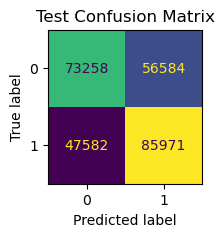

In [42]:
y_test_pred = rf_classifier.predict(X_test)
cm_test = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(cm_test)
fig, ax = plt.subplots(figsize=(2, 2))
disp.plot(ax=ax, colorbar = None)
plt.title("Test Confusion Matrix")
save_figure("RF_catPd_test")

all_metrics(y_test, y_test_pred)

In [43]:
all_metrics_tex(y_test, y_test_pred)

\begin{align*}
\mathrm{accuracy}: 0.605,\quad
\mathrm{sensitivity}: 0.644,\quad
\mathrm{specificity}: 0.564,\quad
\mathrm{kappa}: 0.208
\end{align*}


## catPdDistrict_strs

In [49]:
# Split dataset into 70% training set and 30% test set
X_train, X_test, y_train, y_test = prepare_data("catPdDistrict_strs")

### max_d = 10, min_d = 5

In [63]:
rf_classifier = RandomForestClassifier(max_depth=10, min_samples_split=5)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=5)

accuracy:	0.594
sensitivity: 	0.680
specificity: 	0.507
kappa:    	0.187


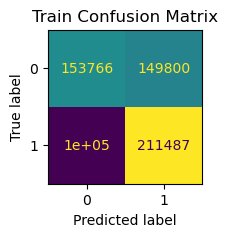

In [64]:
y_train_pred = rf_classifier.predict(X_train)
cm_train = confusion_matrix(y_train, y_train_pred)

disp = ConfusionMatrixDisplay(cm_train)
fig, ax = plt.subplots(figsize=(2, 2))
disp.plot(ax=ax, colorbar = None)
plt.title("Train Confusion Matrix")

all_metrics(y_train, y_train_pred)

accuracy:	0.592
sensitivity: 	0.676
specificity: 	0.507
kappa:    	0.183


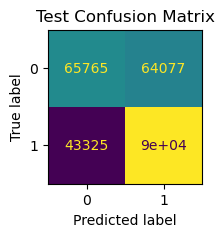

In [65]:
y_test_pred = rf_classifier.predict(X_test)
cm_test = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(cm_test)
fig, ax = plt.subplots(figsize=(2, 2))
disp.plot(ax=ax, colorbar = None)
plt.title("Test Confusion Matrix")

all_metrics(y_test, y_test_pred)

### max_d = 100, min_d = 50

In [50]:
rf_classifier = RandomForestClassifier(max_depth=100, min_samples_split=50)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=100, min_samples_split=50)

Saving figure to file ./cs5630_final_TeX/figures/RF_strs_train.pdf
accuracy:	0.711
sensitivity: 	0.764
specificity: 	0.656
kappa:    	0.421


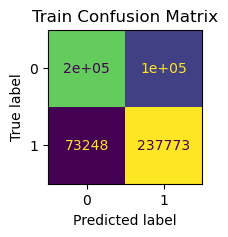

In [51]:
y_train_pred = rf_classifier.predict(X_train)
cm_train = confusion_matrix(y_train, y_train_pred)

disp = ConfusionMatrixDisplay(cm_train)
fig, ax = plt.subplots(figsize=(2, 2))
disp.plot(ax=ax, colorbar = None)
plt.title("Train Confusion Matrix")
save_figure("RF_strs_train")

all_metrics(y_train, y_train_pred)

In [52]:
all_metrics_tex(y_train, y_train_pred)

\begin{align*}
\mathrm{accuracy}: 0.711,\quad
\mathrm{sensitivity}: 0.764,\quad
\mathrm{specificity}: 0.656,\quad
\mathrm{kappa}: 0.421
\end{align*}


Saving figure to file ./cs5630_final_TeX/figures/RF_strs_test.pdf
accuracy:	0.616
sensitivity: 	0.674
specificity: 	0.555
kappa:    	0.230


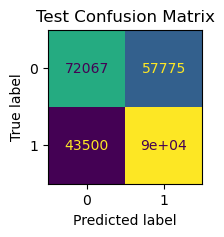

In [53]:
y_test_pred = rf_classifier.predict(X_test)
cm_test = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(cm_test)
fig, ax = plt.subplots(figsize=(2, 2))
disp.plot(ax=ax, colorbar = None)
plt.title("Test Confusion Matrix")
save_figure("RF_strs_test")

all_metrics(y_test, y_test_pred)

In [54]:
all_metrics_tex(y_test, y_test_pred)

\begin{align*}
\mathrm{accuracy}: 0.616,\quad
\mathrm{sensitivity}: 0.674,\quad
\mathrm{specificity}: 0.555,\quad
\mathrm{kappa}: 0.230
\end{align*}


##  Results

In [71]:
with open("./rf_results.txt") as file:
    lines = file.readlines()

In [113]:
def parse_line(L):
    tmp = L.split(":")
    if len(tmp)==2:
        return [tmp[0], float(tmp[1])]
    else:
        print("Problem parsin line ", L)

In [121]:
import re

In [200]:
[L for L in lines if "max" in L][2]

'max_d = 100, min_d = 20\n'

In [203]:
[int(d) for d in re.findall(".+ ([\d\.]+).+ ([\d\.]+)\n", [L for L in lines if "max" in L][2])[0]]

[100, 20]

In [120]:
lines[1]

'max_d = 10, min_d = 5\n'

In [204]:
results_list  = []
data_ = ""
train_prefix = ""
small_dict = dict()
for L in lines:
    # print(L)
    if len(L)==1:
        pass
    elif "[" in L:
        data_ = L
    elif "-" in L:
        train_prefix = L.replace("-","").strip()
    elif "max" in L:
        [max_d, min_split] = [int(d) for d in re.findall(".+ ([\d\.]+).+ ([\d\.]+)", L)[0]]
        small_dict = {"data":data_.strip(), "max_d":max_d, "min_split":min_split}
        if len(small_dict)>0:
            results_list.append(small_dict)
    else:
        [var, val] = parse_line(L)
        small_dict[train_prefix+"_"+var]=val
results_list.append(small_dict)
results_df = pd.DataFrame(results_list) 

In [205]:
results_df

data  max_d  min_split  train_accuracy  train_sensitivity  \
0               [paper]     10          5           0.597              0.652   
1               [paper]    100          5           0.924              0.927   
2               [paper]    100         20           0.801              0.831   
3               [paper]     70         30           0.753              0.795   
4               [paper]    100         50           0.710              0.764   
5       [catPdDistrict]     10          5           0.596              0.631   
6       [catPdDistrict]    100         50           0.742              0.774   
7  [catPdDistrict_strs]     10          5           0.594              0.680   
8  [catPdDistrict_strs]    100         50           0.710              0.764   
9  [catPdDistrict_strs]    100         50           0.710              0.764   

   train_specificity  train_kappa  test_accuracy  test_sensitivity  \
0              0.541        0.194          0.587             0.641   
1              0.920        0.847          0.605             0.637   
2              0.771        0.602          0.614             0.664   
3              0.710        0.506          0.615             0.669   
4              0.655        0.420          0.616             0.674   
5              0.560        0.192          0.587             0.623   
6              0.709        0.483          0.605             0.642   
7              0.507        0.187          0.592             0.676   
8              0.655        0.419          0.616             0.674   
9              0.655        0.419          0.616             0.674   

   test_specificity  test_kappa  
0             0.531       0.173  
1             0.572       0.209  
2             0.563       0.227  
3             0.560       0.229  
4             0.556       0.230  
5             0.551       0.173  
6             0.566       0.208  
7             0.507       0.183  
8             0.555       0.230  
9             0.555       0.230

In [206]:
results_df["max_test_kappa"] = results_df.groupby("data")["test_kappa"].transform("max")
results_df.query("max_test_kappa == test_kappa")

data  max_d  min_split  train_accuracy  train_sensitivity  \
4               [paper]    100         50           0.710              0.764   
6       [catPdDistrict]    100         50           0.742              0.774   
8  [catPdDistrict_strs]    100         50           0.710              0.764   
9  [catPdDistrict_strs]    100         50           0.710              0.764   

   train_specificity  train_kappa  test_accuracy  test_sensitivity  \
4              0.655        0.420          0.616             0.674   
6              0.709        0.483          0.605             0.642   
8              0.655        0.419          0.616             0.674   
9              0.655        0.419          0.616             0.674   

   test_specificity  test_kappa  max_test_kappa  
4             0.556       0.230           0.230  
6             0.566       0.208           0.208  
8             0.555       0.230           0.230  
9             0.555       0.230           0.230